In [1]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import Image

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [ ]:
df_labels = pd.read_csv('../content/drive/MyDrive/DSE_I2100/data/GroundTruth.csv')
df_labels['image'] = df_labels['image'] +'.jpg'

labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list=[]
for i in range (len(df_labels)):
    row= list(df_labels.iloc[i])
    del row[0]
    index=np.argmax(row)
    label=labels[index]
    label_list.append(label)
df_labels['label']= label_list
df_labels=df_labels.drop(labels, axis=1)
df_labels['label'].value_counts()

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64

In [ ]:
df_labels.head()

,image,label
0,ISIC_0024306.jpg,NV
1,ISIC_0024307.jpg,NV
2,ISIC_0024308.jpg,NV
3,ISIC_0024309.jpg,NV
4,ISIC_0024310.jpg,MEL


In [ ]:
sdir=r'../content/drive/MyDrive/DSE_I2100/data/images' # main directory where data is stored
save_dir=r'./' # output directory where model will be saved
subject='cancer' # part of the name of the saved model
height=64  # image height
width=64   # image width
channels=3  # number of coloor channels
batch_size=40  # model batch size for training and evaluation
img_shape=(height, width, channels)
img_size=(height, width)

def scalar(img): # unused for efficientnet model
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator() # no scaling of pixels is need for efficientnet

df_gen=gen.flow_from_dataframe( df_labels, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 10015 validated image filenames belonging to 7 classes.


In [ ]:
def show_image_samples(gen):
    test_dict=gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255 # scale images between 0 and 1 becaue no preprocessing scaling was done for efficientnet
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

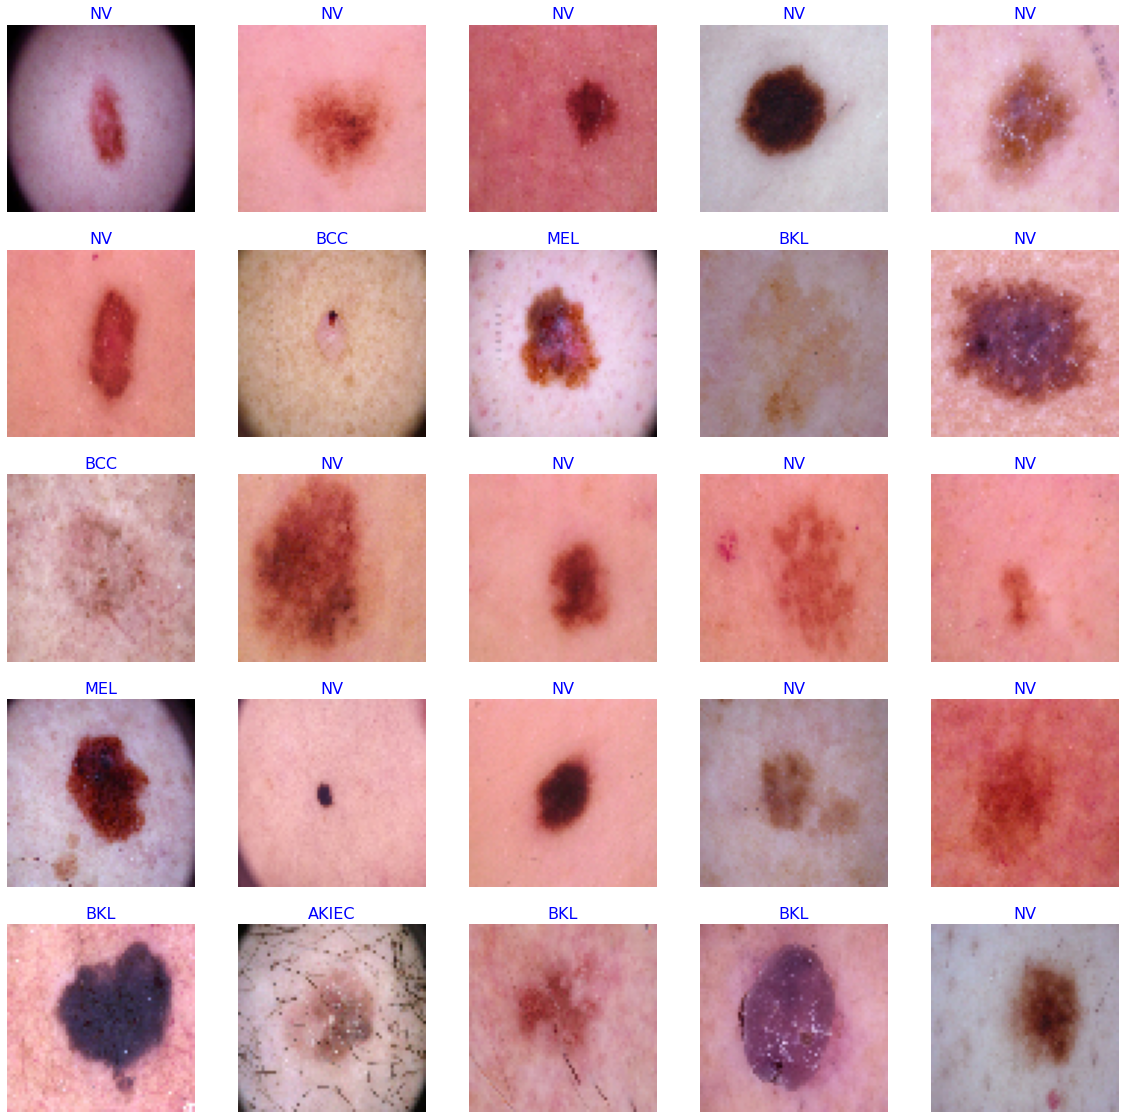

In [ ]:
show_image_samples(df_gen)

In [14]:
data_directory = "/content/drive/MyDrive/DSE_I2100/data/"
os.listdir(data_directory)
data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))


In [15]:
image_directory = "/content/drive/MyDrive/DSE_I2100/data/images/"
def getPath(image_id):
  return image_directory + image_id + ".jpg"

In [16]:
data['path'] = data['image_id'].map(lambda x : getPath(x))

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   path          10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [35]:
data.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [36]:
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
data['age'] = data['age'].astype('int32')

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lesion_id     10015 non-null  object
 1   image_id      10015 non-null  object
 2   dx            10015 non-null  object
 3   dx_type       10015 non-null  object
 4   age           10015 non-null  int32 
 5   sex           10015 non-null  object
 6   localization  10015 non-null  object
 7   path          10015 non-null  object
dtypes: int32(1), object(7)
memory usage: 586.9+ KB


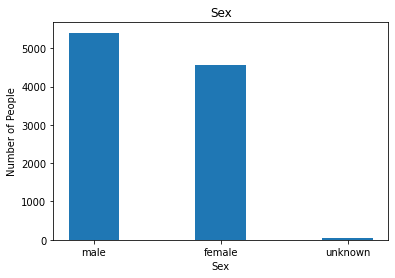

In [38]:
plt.bar(data['sex'].value_counts().index, data['sex'].value_counts(), width = 0.4)
plt.xlabel("Sex")
plt.ylabel("Number of People")
plt.title("Sex")
plt.show()

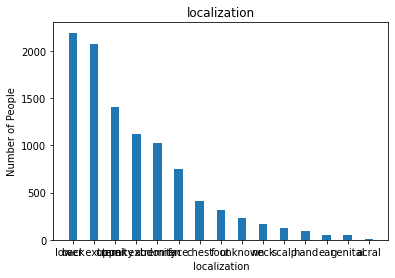

In [39]:
plt.bar(data['localization'].value_counts().index, data['localization'].value_counts(), width = 0.4)
plt.xlabel("localization")
plt.ylabel("Number of People")
plt.title("localization")
plt.show()

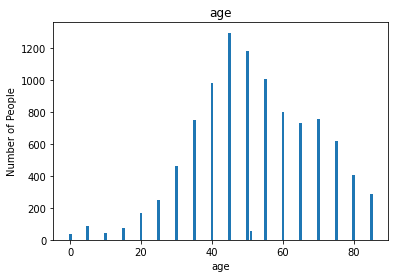

In [40]:
plt.bar(data['age'].value_counts().index, data['age'].value_counts())
plt.xlabel("age")
plt.ylabel("Number of People")
plt.title("age")
plt.show()

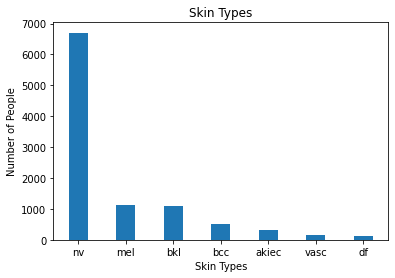

In [41]:
plt.bar(data['dx'].value_counts().index, data['dx'].value_counts(), width = 0.4)
plt.xlabel("Skin Types")
plt.ylabel("Number of People")
plt.title("Skin Types")
plt.show()